In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import math
import yfinance as yf
import datetime
from sklearn.metrics import mean_squared_error

In [15]:
start = '2012-01-01'
end = datetime.datetime.now().strftime('%Y-%m-%d')
stock = 'AAPL'
# Get the data
df = yf.download(stock, start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


In [16]:
df.reset_index(inplace=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,14.621429,14.732143,14.607143,14.686786,12.416986,302220800
1,2012-01-04,14.642857,14.810000,14.617143,14.765714,12.483709,260022000
2,2012-01-05,14.819643,14.948214,14.738214,14.929643,12.622310,271269600
3,2012-01-06,14.991786,15.098214,14.972143,15.085714,12.754256,318292800
4,2012-01-09,15.196429,15.276786,15.048214,15.061786,12.734026,394024400
...,...,...,...,...,...,...,...
3121,2024-05-30,190.759995,192.179993,190.630005,191.289993,191.289993,49947900
3122,2024-05-31,191.440002,192.570007,189.910004,192.250000,192.250000,75158300
3123,2024-06-03,192.899994,194.990005,192.520004,194.029999,194.029999,50080500
3124,2024-06-04,194.639999,195.320007,193.029999,194.350006,194.350006,47471400


In [17]:
ma_100_days = df['Close'].rolling(100).mean()


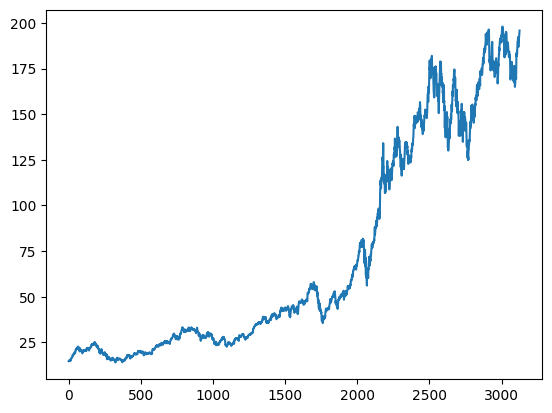

In [18]:
df2 = df.reset_index()['Close']
plt.plot(df2)


In [19]:
scaler = MinMaxScaler()
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))
df2.shape

(3126, 1)

## Training...  ##

In [20]:
train_size = int(len(df2)*0.65)
test_size = len(df2) - train_size
train_data,test_data = df2[0:train_size,:],df2[train_size:len(df2),:1]

In [21]:
def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
                   a = dataset[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [22]:
# calling the create dataset function to split the data into 
# input output datasets with time step 100
time_step = 100
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [23]:
# checking values
print(X_train.shape)
print(X_train)
print(X_test.shape)
print(Y_test.shape)

(1930, 100)
[[0.00401431 0.00444289 0.00533302 ... 0.0322774  0.03491288 0.0338967 ]
 [0.00444289 0.00533302 0.00618049 ... 0.03491288 0.0338967  0.03330909]
 [0.00533302 0.00618049 0.00605056 ... 0.0338967  0.03330909 0.03524449]
 ...
 [0.20762914 0.20350234 0.20824001 ... 0.35400802 0.355542   0.35761896]
 [0.20350234 0.20824001 0.21379216 ... 0.355542   0.35761896 0.35637005]
 [0.20824001 0.21379216 0.21376501 ... 0.35761896 0.35637005 0.3436639 ]]
(994, 100)
(994,)


## Creating and fitting LSTM model ##

In [24]:
model = Sequential()
model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

C:\Users\jestebangil\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 100,batch_size = 64,verbose = 1)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 1.5857e-04 - val_loss: 0.0029
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 1.0033e-04 - val_loss: 0.0064
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - loss: 8.8851e-05 - val_loss: 0.0048
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - loss: 9.1945e-05 - val_loss: 0.0059
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - loss: 9.3426e-05 - val_loss: 0.0035
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 9.4494e-05 - val_loss: 0.0049
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 7.1272e-05 - val_loss: 0.0048
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 6.1275e-05 - val_loss: 0.0065
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 6.9642e-05 - val_loss: 0.0083
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - loss: 6.9547e-05 - val_loss: 0.0019
E

In [27]:
model.save('stock_prediction2.h5', save_format = 'h5')

In [28]:
model.compiled_metrics

<keras.src.backend.tensorflow.trainer.TensorFlowTrainer.compiled_metrics.<locals>.DeprecatedCompiledMetric at 0x1b870e73fb0>

In [29]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


In [30]:
# transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [31]:
print(math.sqrt(mean_squared_error(Y_train,train_predict)))
print(math.sqrt(mean_squared_error(Y_test,test_predict)))

35.103567080640296
156.2054837751722


## Graph plotting ##

In [32]:
look_back = 100

In [33]:
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

In [34]:
testPredictPlot = np.empty_like(df2)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(df2) - 1,:] = test_predict

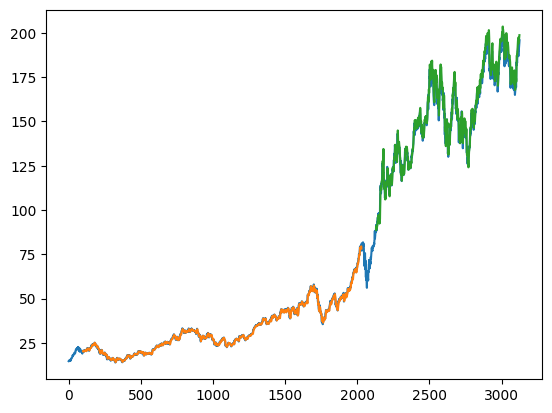

In [35]:
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()